In [12]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas  # used to load metadata table
import numpy as np
import sys
import lmfit as lmfit
import glob as glob



import numpy as np
import os
from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm


import pandas as pd
import pickle
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from matplotlib import rc
import h5py
import os

from scipy import interpolate
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import midtools



Functions and variables for contrast

In [13]:
# variables
bs         = np.sqrt(8.59*9.9)*1e-6    # beam size in m
d         =  1.5e-3   # sample thickness in m
E         = 9        # Energy in keV
L         = 7   # sample-detector-distance in m
delLamLam = 2e-3     # Delta E over E: pink: 2e-3, in felix paper it is fixed at 5e-3 for some reason
P         = 200e-6    # pixel size in m



def calculate_M_det(E,q,delLamLam,bs,L,P,d):

    theta = calculate_theta(q,E)
    M_rad = calculate_M_rad(q,delLamLam,bs,E)
    M_det = np.sqrt(1+P**4*bs**2/(M_rad**2*(wavelength(E))**4*L**4)*( (bs**2)*np.cos(theta/2)**2+ (d**2)*np.sin(theta/2)**2) )

    return M_det


def calculate_M_rad(q,delLamLam,bs,E):
    theta=calculate_theta(q,E)
    M_rad=np.sqrt(1+(q**2)*(delLamLam**2)/(4*np.pi**2)*((bs**2)*(np.cos(theta))**2 + (d**2)*(np.sin(theta))**2 ))
    return M_rad


def speckle_contrast(E,q,delLamLam,bs,L,P,d):
    q=q*1e9
    beta = .5/(calculate_M_rad(q,delLamLam,bs,E)*calculate_M_det(E,q,delLamLam,bs,L,P,d))
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam


def calculate_theta(q,E):
    theta=np.arcsin(q/(4*np.pi/wavelength(E)))
    return theta



Functions for loading

In [25]:

def load_data_corrected(pathtodata,filenumbers, tmax,qrange):
    "function to load ttcs corrected with the ttc with stride 1, energy, positions"
    files=[]
    for run in filenumbers:
        os.chdir(pathtodata)
        for file in glob.glob(f"r{run:04d}*.h5"):
            files.append(file)
    files=sorted(files)

    f=h5py.File(pathtodata+files[0], 'r')
    
    ttcs=f['train_resolved/correlation/ttc'][:,0,qrange,:tmax,:tmax]-f['train_resolved/correlation/ttc'][:,1,qrange,:tmax,:tmax]+1
    positions =f['train_resolved/sample_position/y'][:,1]
    positionsz=f['train_resolved/sample_position/y'][:,2]
    energy=f['pulse_resolved/xgm/energy'][:,:tmax]
    qvalues=f['train_resolved/correlation/q'][qrange]

    for filename in files[1:]:
        try:
            f=h5py.File(pathtodata+filename, 'r')
            ttcs=np.append(ttcs, f['train_resolved/correlation/ttc'][:,0,qrange,:tmax,:tmax]-f['train_resolved/correlation/ttc'][:,1,qrange,:tmax,:tmax]+1, axis=0)
            energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:tmax], axis=0)
            positions =np.append(positions,f['train_resolved/sample_position/y'][:,1])
            positionsz=np.append(positionsz,f['train_resolved/sample_position/y'][:,2])
            #average_intensity=np.append(average_intensity,f['average/image_2d'][:])
            print(f'loaded {filename}')
        except KeyError:
            print(f'ttc of {filename} not found')
        except FileNotFoundError:
            print(f'file {filename} not found')
    
    return(ttcs,qvalues,positions,positionsz,energy)#positionsz,energy,t_delay,



def check_files(pathtodata,filenumbers):
    "function to load ttcs corrected with the ttc with stride 1, energy, positions"
    files=[]
    for run in filenumbers:
        os.chdir(pathtodata)
        for file in glob.glob(f"r{run:04d}*.h5"):
            files.append(file)
    files=sorted(files)

    for filename in files[:]:
        try:
            f=h5py.File(pathtodata+filename, 'r')
            f['train_resolved/correlation/ttc'][0,0,0,1,1]
            #print(str(f['identifiers/train_indices'][-1])+'-'+str(f['identifiers/train_indices'][-1]))
        except KeyError:
            print(f'ttc of {filename} not found')

            print(str(f['identifiers/train_indices'][0])+'-'+str(f['identifiers/train_indices'][-1])+"over"+str(len(f['identifiers/complete_trains'])))
        except FileNotFoundError:
            print(f'file {filename} not found')
    
    return()#positionsz,energy,t_delay,

def load_saxs(pathtodata,filenames):
    "Function to load saxs, average 2d image, energy and sample position"
    f=h5py.File(pathtodata+filenames[0], 'r')
    I=f['pulse_resolved/azimuthal_intensity/I'][:]
    q=f['pulse_resolved/azimuthal_intensity/q'][:]
    positions =f['train_resolved/sample_position/y'][:,1]
    positionsz=f['train_resolved/sample_position/y'][:,2]
    energy=f['pulse_resolved/xgm/energy'][:,:tmax]
    average_intensity=f['average/intensity'][:]

    for filename in filenames[1:]:
        f=h5py.File(pathtodata+filename, 'r')
        I=np.append(I, f['pulse_resolved/azimuthal_intensity/I'][:], axis=0)
        energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:tmax], axis=0)
        positions =np.append(positions,f['train_resolved/sample_position/y'][:,1])
        positionsz=np.append(positionsz,f['train_resolved/sample_position/y'][:,2])
        average_intensity=np.append(average_intensity,f['average/intensity'][:])


    return(q,I,average_intensity,positions,positionsz,energy)#t_delay,


Functions for masking and correcting ttcs 

In [26]:
def put_mask_ttc(ttcs):

    problematic_pixel=30
    problematic_pixel2=62
    problematic_pixel3=94


    ttcs[:,:,problematic_pixel,:problematic_pixel]=np.nan
    ttcs[:,:,:problematic_pixel,problematic_pixel]=np.nan
    ttcs[:,:,problematic_pixel+1,problematic_pixel+1:]=np.nan
    ttcs[:,:,problematic_pixel+1:,problematic_pixel+1]=np.nan


    ttcs[:,:,problematic_pixel2,:problematic_pixel2]=np.nan
    ttcs[:,:,:problematic_pixel2,problematic_pixel2]=np.nan
    ttcs[:,:,problematic_pixel2+1,problematic_pixel2+1:]=np.nan
    ttcs[:,:,problematic_pixel2+1:,problematic_pixel2+1]=np.nan

    ttcs[:,:,problematic_pixel3,:]=np.nan
    ttcs[:,:,:,problematic_pixel3]=np.nan
    return(ttcs)



    
def ttc_baseline_correction(ave_ttc):
    baseline_corrected_ttc=[]
    cut_pixel=20
    problematic_pixel=30
    problematic_pixel2=62
    problematic_pixel3=94


    baseline_lowerquadrant = np.nanmean(np.diag(ave_ttc, k=cut_pixel)[:problematic_pixel-cut_pixel])
    baseline_middlequadrant = np.nanmean(np.diag(ave_ttc, k=cut_pixel)[problematic_pixel+2:problematic_pixel2-cut_pixel])
    baseline_upperquadrant = np.nanmean(np.diag(ave_ttc, k=cut_pixel)[problematic_pixel2+2:problematic_pixel3-cut_pixel])

    baseline_remaining=np.nanmean(np.diag(ave_ttc, k=cut_pixel)[problematic_pixel-cut_pixel+1:problematic_pixel2-problematic_pixel-1])

    baseline_corrected_ttc=ave_ttc.copy()
    baseline_corrected_ttc[:problematic_pixel,:problematic_pixel]+=-baseline_lowerquadrant+baseline_remaining
    baseline_corrected_ttc[problematic_pixel+1:problematic_pixel2,problematic_pixel+1:problematic_pixel2]+= -baseline_middlequadrant+baseline_remaining
    baseline_corrected_ttc[problematic_pixel2+1:problematic_pixel3,problematic_pixel2+1:problematic_pixel3]+= -baseline_upperquadrant+baseline_remaining

    baseline_corrected_ttc[problematic_pixel,:problematic_pixel]=np.nan
    baseline_corrected_ttc[:problematic_pixel,problematic_pixel]=np.nan
    baseline_corrected_ttc[problematic_pixel+1,problematic_pixel+1:]=np.nan
    baseline_corrected_ttc[problematic_pixel+1:,problematic_pixel+1]=np.nan
    

    baseline_corrected_ttc[problematic_pixel2,:problematic_pixel2]=np.nan
    baseline_corrected_ttc[:problematic_pixel2,problematic_pixel2]=np.nan
    baseline_corrected_ttc[problematic_pixel2+1,problematic_pixel2+1:]=np.nan
    baseline_corrected_ttc[problematic_pixel2+1:,problematic_pixel2+1]=np.nan

    baseline_corrected_ttc[problematic_pixel3,:]=np.nan
    baseline_corrected_ttc[:,problematic_pixel3]=np.nan

    for i in range(np.size(ave_ttc,0)):
        baseline_corrected_ttc[i,i]=ave_ttc[i,i]
    
    #baseline_corrected_ttc=baseline_corrected_ttc/np.nanmean(baseline_corrected_ttc[80:,:5])

    return(baseline_corrected_ttc)

Functions for g2 definition and fitting

In [27]:
def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    dg2 = []
    
    for i in range(1,ttc.shape[0]):
        g2.append(np.nanmean(np.diag(ttc, k=i)))
        dg2.append(np.nanstd(np.diag(ttc, k=i))/np.sqrt(len(np.diag(ttc, k=i))))
    return g2,dg2


    
def exp_fun(x, A, tau,beta,inter):
    res = A * np.exp(-2*(x / tau) ** beta)+inter
    return res

    

In [28]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9/p003094/'
proposal = 3094


filenames_1_60mgml_23C=np.arange(115,134)
filenames_1_60mgml_0C=np.arange(177,189)
filenames_1_60mgml_m20C=np.arange(213,224)

filenames_2_60mgml_23C=np.arange(127,134)
filenames_2_60mgml_0C=np.arange(189,201)
filenames_2_60mgml_m20C=np.arange(201,213)

filenames_10_60mgml_23C=np.arange(136,140)



filenames_2_70mgml=[77,78]
filenames_1_70mgml=[58,60,63,65]
filenames_p6_70mgml=np.arange(70,77)

filenames_10_15mgml=[263,264]
filenames_2_15mgml=np.arange(259,263)
filenames_1_15mgml=np.arange(255,259)
filenames_p6_15mgml=np.arange(249,255)


filenames_4=[98,99]
filenames_2=[79,80]
filenames_1=np.arange(81,85)
filenames_p6=[85,86]+list(np.arange(89,97))

vycor=[107]

si100nm=[104,105,111,112,113,114]
si20nm=[57]


tmax=100
t_delay=.44
qrange=np.arange(15)

In [146]:
def check_files(pathtodata,filenumbers):
    "function to load ttcs corrected with the ttc with stride 1, energy, positions"
    files=[]
    for run in filenumbers:
        os.chdir(pathtodata)
        for file in glob.glob(f"r{run:04d}*.h5"):
            files.append(file)
    files=sorted(files)

    for filename in files[:]:
        try:
            f=h5py.File(pathtodata+filename, 'r')
            f['train_resolved/correlation/ttc'][0,0,0,1,1]
            print(str(f['identifiers/train_indices'][0])+'-'+str(f['identifiers/train_indices'][-1])+' in '+filename)
        except KeyError:
            print(f'ttc of {filename} not found')

            print(str(f['identifiers/train_indices'][0])+'-'+str(f['identifiers/train_indices'][-1])+" over "+str(len(f['identifiers/complete_trains'])))
        except FileNotFoundError:
            print(f'file {filename} not found')
    
    return()
for i in range(264,266):
    check_files(pathtodata,[i])


7047-7549 in r0264-analysis_001.h5
7550-8055 in r0264-analysis_003.h5
2520-3021 in r0264-analysis_004.h5
8056-8560 in r0264-analysis_005.h5
1008-1512 in r0264-analysis_006.h5
0-504 in r0264-analysis_008.h5
5033-5534 in r0264-analysis_012.h5
505-1007 in r0264-analysis_013.h5
3022-3523 in r0264-analysis_014.h5
4532-5032 in r0264-analysis_015.h5
4027-4531 in r0264-analysis_016.h5
6038-6540 in r0264-analysis_018.h5
6541-7046 in r0264-analysis_019.h5
ttc of r0264-analysis_020.h5 not found
9064-9948 over 9877


In [25]:
ttcs,qvalues,positions,positionsz,energy=load_data_corrected(pathtodata,filenames_2,tmax,qrange)
print(r'data loaded')




loaded r0079-analysis_001.h5
loaded r0080-analysis_000.h5
loaded r0080-analysis_001.h5
loaded r0080-analysis_002.h5
loaded r0080-analysis_003.h5
loaded r0080-analysis_004.h5
loaded r0080-analysis_006.h5
loaded r0080-analysis_007.h5
loaded r0080-analysis_008.h5
loaded r0080-analysis_009.h5
loaded r0080-analysis_010.h5
loaded r0080-analysis_011.h5
loaded r0080-analysis_012.h5
loaded r0080-analysis_013.h5
loaded r0080-analysis_014.h5
loaded r0080-analysis_015.h5
loaded r0080-analysis_016.h5
loaded r0080-analysis_017.h5
loaded r0080-analysis_018.h5
data loaded


In [9]:
ttcs=put_mask_ttc(ttcs)
np.shape(ttcs)

(9002, 15, 100, 100)

Filters for position and energy

7137


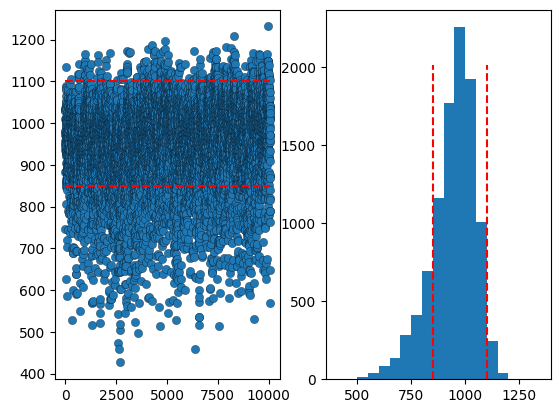

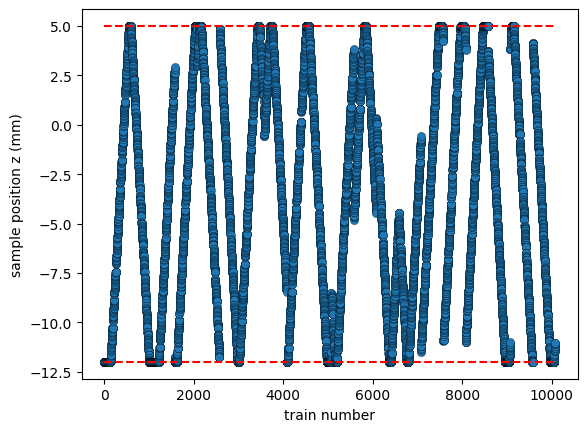

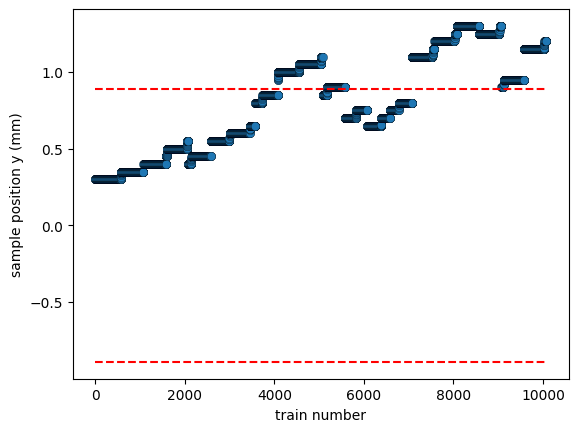

In [31]:

mean_energy=np.mean(energy[:,:10],1)
min_energy=850
max_energy=1100

plt.figure()
plt.subplot(1,2,1)
plt.plot(mean_energy,marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.hlines(min_energy,0, len(mean_energy),color='red',ls='dashed')
plt.hlines(max_energy,0, len(mean_energy),color='red',ls='dashed')

plt.subplot(1,2,2)
n_energy,x,_ =plt.hist(mean_energy,np.arange(400,1400,50))
bin_centers_energy = 0.5*(x[1:]+x[:-1])

plt.vlines(min_energy,0, len(mean_energy)/5,color='red',ls='dashed')
plt.vlines(max_energy,0, len(mean_energy)/5,color='red',ls='dashed')

filtering_energy=(mean_energy>min_energy)&(mean_energy<max_energy)


minpositionz=-12
maxpositionz=5

minposition=-.89
maxposition=.89

plt.figure()
plt.plot(positionsz,marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.hlines(minpositionz,0, len(positions),color='red',ls='dashed')
plt.hlines(maxpositionz,0, len(positions),color='red',ls='dashed')
plt.xlabel('train number')
plt.ylabel('sample position z (mm)')

plt.figure()
plt.plot(positions,marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.hlines(minposition,0, len(positions),color='red',ls='dashed')
plt.hlines(maxposition,0, len(positions),color='red',ls='dashed')
plt.xlabel('train number')
plt.ylabel('sample position y (mm)')


filtering_positions=(positionsz<maxpositionz)&(positionsz>minpositionz)#&(positionsz<maxpositionz)&(positionsz>minpositionz)

print(sum(filtering_positions&filtering_energy))


Calculation of ttc applying filter on position, energy, standard deviation in one ttc, mean of a ttc

[0.21666667 0.25       0.28333333 0.31666667 0.35       0.38333333
 0.41666667 0.45       0.48333333 0.51666667 0.55       0.58333333
 0.61666667 0.65       0.68333333]
q=0
std threshold value: 0.5625
number of averaged files: 6489
q=1
std threshold value: 0.41250000000000003
number of averaged files: 6312
q=2
std threshold value: 0.41250000000000003
number of averaged files: 6526
q=3
std threshold value: 0.3375
number of averaged files: 6437
q=4
std threshold value: 0.3375
number of averaged files: 6251
q=5
std threshold value: 0.2625
number of averaged files: 6628
q=6
std threshold value: 0.1875
number of averaged files: 6153
q=7
std threshold value: 0.1875
number of averaged files: 6232
q=8
std threshold value: 0.1875
number of averaged files: 6053
q=9
std threshold value: 0.2625
number of averaged files: 6588
q=10
std threshold value: 0.2625
number of averaged files: 5715
q=11
std threshold value: 0.3375
number of averaged files: 6583
q=12
std threshold value: 0.41250000000000003
n

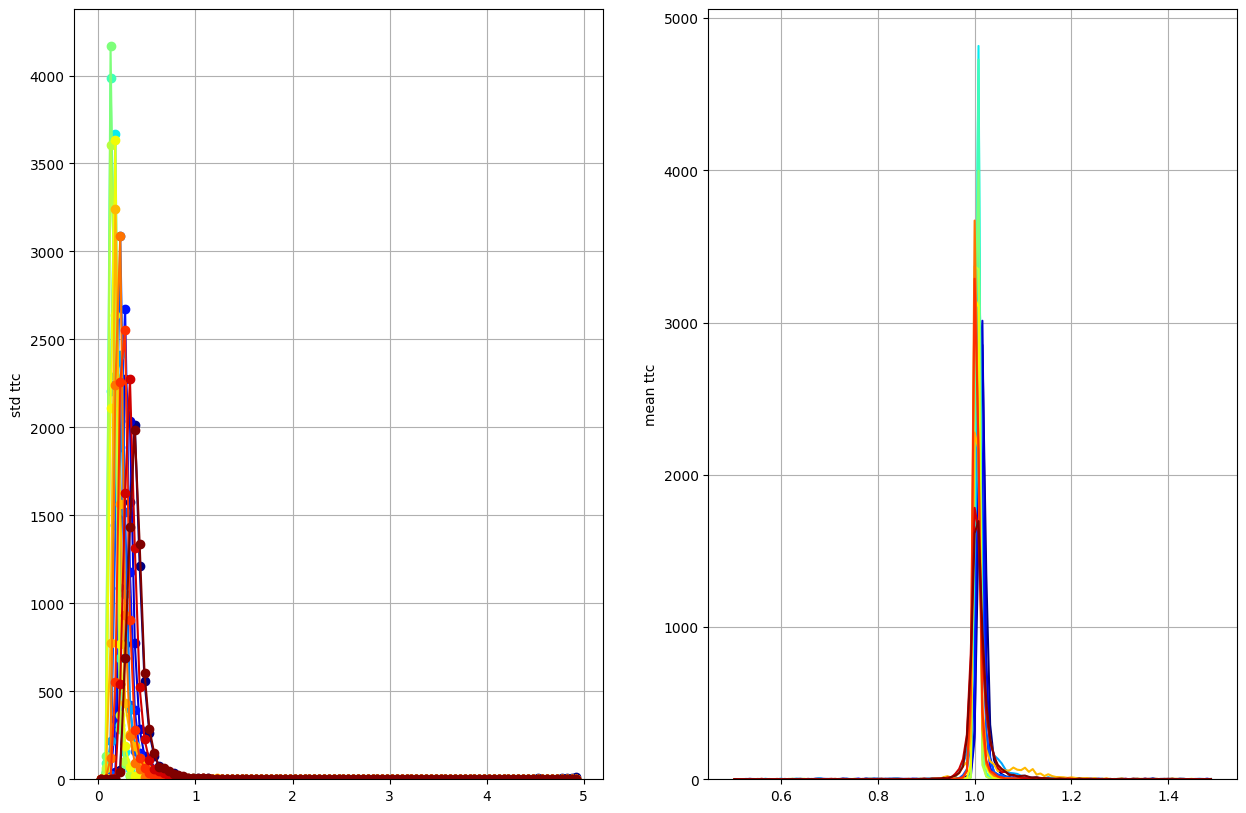

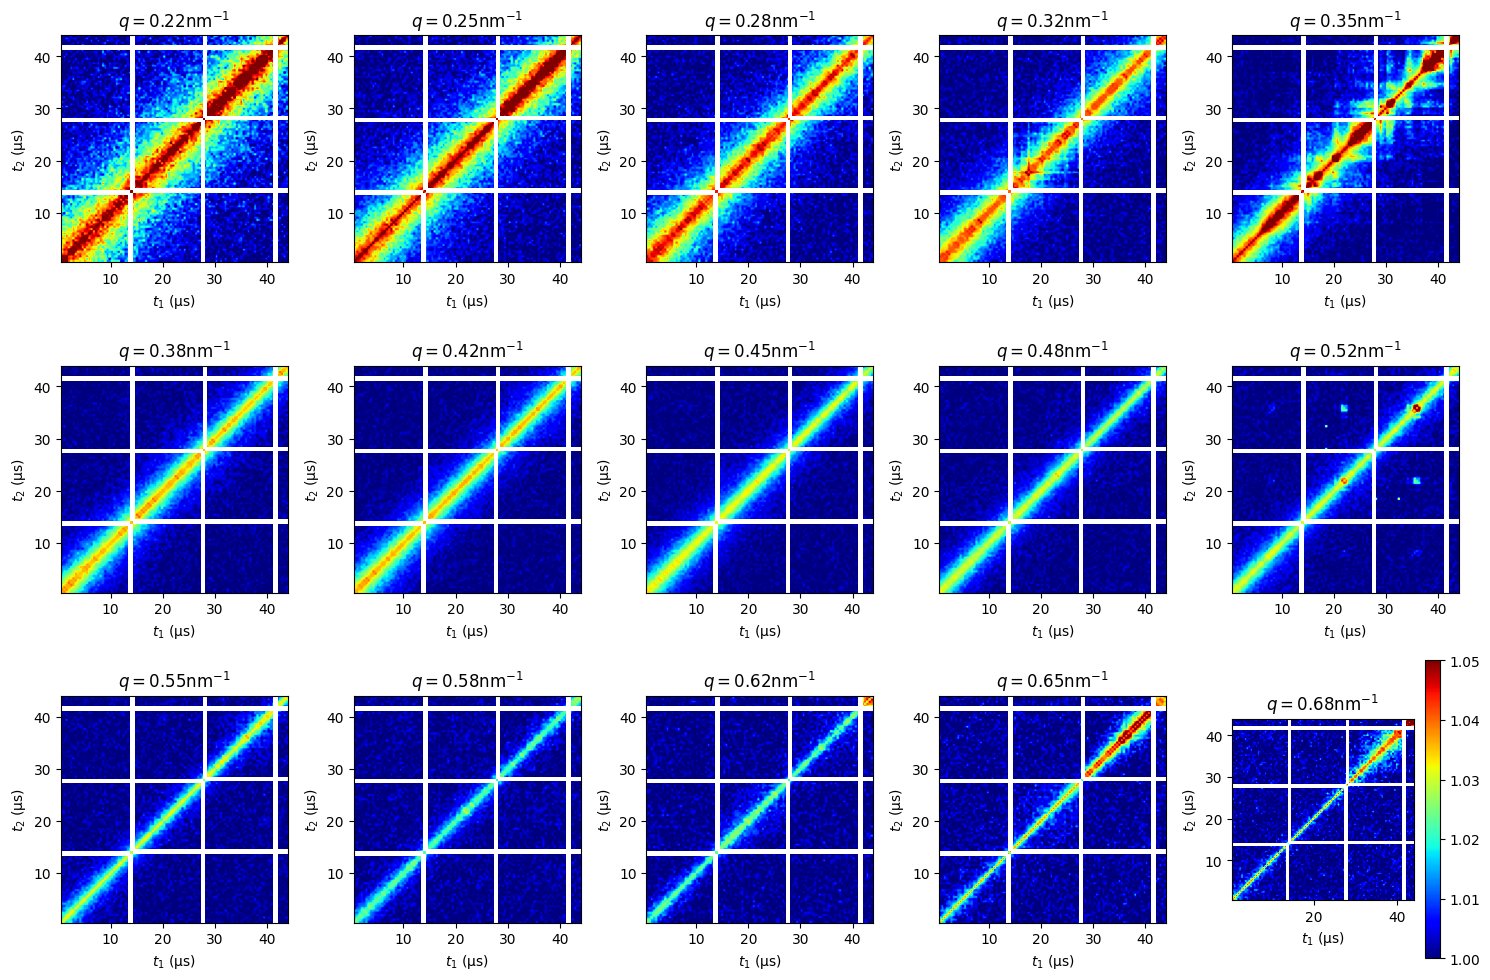

In [32]:
print(qvalues)
qnum=len(qvalues)
qmin=0
qmax=qnum
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))


t_new=np.arange(1000)*.1

tminframes=0

totframes=100
tmaxframes=100
tmax_mean=100

minttcmean=.9
maxttcmean=1.1



t=np.arange(1,tmaxframes-tminframes)*t_delay

stride=0


fig2=plt.figure(figsize=(15,10))
fig1=plt.figure(figsize=(15,10))

allg2=[]
alldg2=[]

contrast =speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)


all_ttcs=np.zeros([qmax-qmin,totframes,totframes])


bins_std=np.arange(0,5,0.05)
bins_mean=np.arange(.5,1.5,0.008)

n_std_all=np.zeros([qmax-qmin,len(bins_std)-1])
n_mean_all=np.zeros([qmax-qmin,len(bins_mean)-1])
high_std_threshold_all=np.zeros([qmax-qmin])

n_tot_files=np.zeros([qmax-qmin])

for i,q in enumerate(range(qmin,qmax)):
    print(f'q={q}')
    #value_mean = np.average(ttcs[:,q,:totframes,:totframes],axis=(1,2))#np.average(ttcs_raw[:,stride,q,:totframes,:totframes],axis=(1,2))
    value_mean = np.nanmean(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
    value_std  = np.nanstd(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
    

    plt.figure(fig1)
    plt.subplot(1,2,1)
    n_std,x,_ = plt.hist(value_std[filtering_energy&filtering_positions],bins_std,alpha=0,color=colore[i])
    bin_centers_std = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers_std,n_std,color=colore[i],marker='o')
    plt.ylabel('std ttc')
    
    plt.grid('on')

    plt.subplot(1,2,2)
    n_mean,x,_ = plt.hist(value_mean[filtering_energy&filtering_positions],bins_mean,alpha=0,color=colore[i])
    bin_centers_mean = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers_mean,n_mean,color=colore[i])
    plt.grid('on')
    plt.ylabel('mean ttc')

    #low_ttc_threshold=bin_centers_mean[n_mean==max(n_mean)]-(bin_centers_mean[n_mean==max(n_mean)]-1)*.3
    #high_ttc_threshold=bin_centers_mean[n_mean==max(n_mean)]+(bin_centers_mean[n_mean==max(n_mean)]-1)*.3
    high_std_threshold=bin_centers_std[n_std==max(n_std)]+(bin_centers_std[n_std==max(n_std)])*.5
    high_std_threshold_all[q]=high_std_threshold
    
    print(f'std threshold value: {high_std_threshold[0]}')
    # ''

    n_std_all[q,:]=n_std
    n_mean_all[q,:]=n_mean

    filtering_mean=(value_mean>minttcmean)&(value_mean<maxttcmean)
    filtering_std=(value_std<high_std_threshold[0])
    #filtering_ratio=((value_mean-1)/value_std>.15)&((value_mean-1)/value_std<.4)
    
    good_trains=filtering_positions&filtering_energy&filtering_mean&filtering_std
    print(f'number of averaged files: {sum(good_trains)}')
    n_tot_files=sum(good_trains)


    ave_ttc=np.nanmean(ttcs[good_trains,q,:totframes,:totframes],axis=0)
    ave_ttc_baselinecorrected=ttc_baseline_correction(ave_ttc) 

    all_ttcs[q,:,:]=ave_ttc_baselinecorrected[:]


    plt.figure(fig2)
    plt.subplot(3,5,q-qmin+1)

    plt.imshow(ave_ttc_baselinecorrected,origin='lower',cmap='jet',vmin=1,vmax=1.05,extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes,))
    plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    
    if q==qmax-1:
        plt.colorbar()
    plt.tight_layout()
    plt.ylabel('$t_2$ (μs)')
    plt.xlabel('$t_1$ (μs)')
    
    
    
    g2,dg2=calculate_g2(ave_ttc_baselinecorrected[tminframes:tmaxframes,tminframes:tmaxframes])
 
    allg2.append(g2)
    alldg2.append(dg2)



In [2]:
namefile='c_120_abs2_RT'

np.savez(f'{pathtodata}{namefile}.npz',
    ttcs=all_ttcs,
    q=qvalues,
    
    bin_centers_std=bin_centers_std,
    n_std_all=n_std_all,
    high_std_threshold_all=high_std_threshold_all,
    
    bin_centers_mean=bin_centers_mean,
    n_mean_all=n_mean_all,
    minttcmean=minttcmean,
    maxttcmean=maxttcmean,
    
    bin_centers_energy=bin_centers_energy,
    n_energy=n_energy,
    min_energy=min_energy,
    max_energy=max_energy,

    maxposition=maxposition,
    minposition=minposition,

    maxpositionz=maxpositionz,
    minpositionz=minpositionz,

    position_filter='z',

    n_tot_files=n_tot_files,

                 )

NameError: name 'pathtodata' is not defined

In [3]:

y=np.array(allg2[qmin:qmax]).flatten()
qgrid=np.repeat(qvalues[qmin:qmax],len(t))
times=np.array([t]*len(qvalues[qmin:qmax])).flatten()

x=np.zeros([len(qgrid),2])
x[:,0]=times
x[:,1]=qgrid


def kww_function(kww,q):
    kww_new=(1-kww*q)

    return(kww_new)

def exp_qdep(x,kww,A,baseline,tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15):

    tau=np.array([tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15])
    
    t=x[:,0]
    qvalues=x[:,1]
    contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
    tau_new=np.repeat(tau,len(t)/15)
    result=A*contrast*np.exp(-(t/(tau_new))**kww_function(kww,qvalues))+baseline
    
    
    return(result)
 
#exp_qdep(x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

NameError: name 'allg2' is not defined

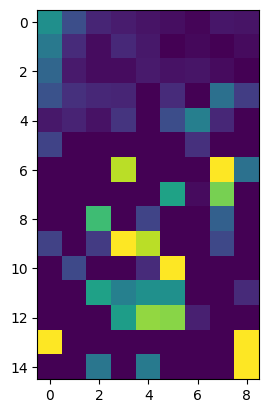

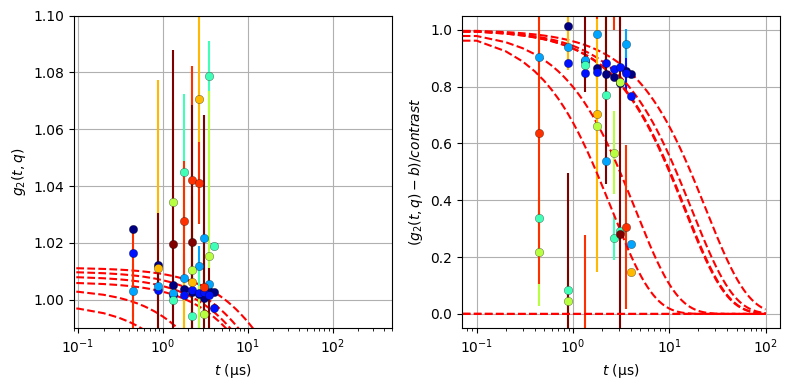

In [84]:
qmax=15
contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
A, beta, inter = (0 for i in range(3))
dA, dbeta, dinter = (0 for i in range(3))
tau,dtau=(np.zeros([qmax-qmin]) for i in range(2))
deltac=0.001


plt.figure()
plt.imshow(allg2,vmin=1, vmax=1.05)


y=np.array(allg2[qmin:qmax]).flatten()
qgrid=np.repeat(qvalues[qmin:qmax],len(t))
times=np.array([t]*len(qvalues[qmin:qmax])).flatten()


x=np.zeros([len(qgrid),2])
x[:,0]=times
x[:,1]=qgrid

param_lowerboundary = list(np.array([  -.003,         0.1,       .9   ]  +list(0*qvalues[qmin:qmax])    ).flatten())
param_upperboundary = list(np.array([   .003,         .44,      1.1  ]  +list(0*qvalues[qmin:qmax]+400)).flatten())
param_initialguess  = list(np.array([   0,        .42,      1.0001]  +list(1/(qvalues[qmin:qmax]**2*2))  ).flatten())


popt, pcov = curve_fit(exp_qdep, xdata=x, ydata=y, sigma=x[:,0]**.5,
                   bounds=(param_lowerboundary,
                            param_upperboundary),
                        p0=param_initialguess )


kww= popt[0]
dkww = np.sqrt(np.diag(pcov))[0]

A = popt[1]
dA = np.sqrt(np.diag(pcov))[1]


baseline= popt[2]
dbaseline = np.sqrt(np.diag(pcov))[2]

for n,i in enumerate(range(3,len(popt))):
    tau[n]= popt[i]
    dtau[n] = np.sqrt(np.diag(pcov))[i]


plt.figure(figsize=(8,4))
for i,q in enumerate(range(qmin,qmax,2)):

    x_new=t_new

    y_new=A*contrast[q]*np.exp(-(t_new/(tau[q]))**kww_function(kww,qvalues[q]))+baseline
    

    plt.subplot(1,2,1)
    plt.errorbar(t,(allg2[q]) ,alldg2[q],marker='o',ls=' ',color=colore[q-qmin],
        label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')
        
    plt.plot(x_new,y_new, color='red',linestyle='dashed')
    
    
    plt.subplot(1,2,2)

    plt.errorbar(t,(allg2[q]-baseline)/(contrast[q]*A) ,alldg2[i]/(contrast[q]*A),marker='o',ls=' ',
        color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')

    plt.plot(x_new, (y_new-baseline)/(contrast[q]*A), color='red',linestyle='dashed')
    
plt.xscale('log')
plt.grid('on')
plt.ylim([-.05,1.05])
plt.xlabel('$t$ (μs)')
plt.ylabel('$(g_2(t,q)-b)/contrast$')
plt.tight_layout()

plt.subplot(1,2,1)
#plt.legend(loc='upper right')
plt.xscale('log')
plt.xlim([.09, 500])
plt.grid('on')
plt.ylim([1-0.01,1.1])
plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,q)$')
plt.tight_layout()




kww
-0.0029999999999999996
[1.00035 1.00045 1.00055 1.00065 1.00075 1.00085 1.00095 1.00105 1.00115
 1.00125 1.00135 1.00145 1.00155 1.00165 1.00175]
A
0.43999999999999995
baseline
0.9551225116825011


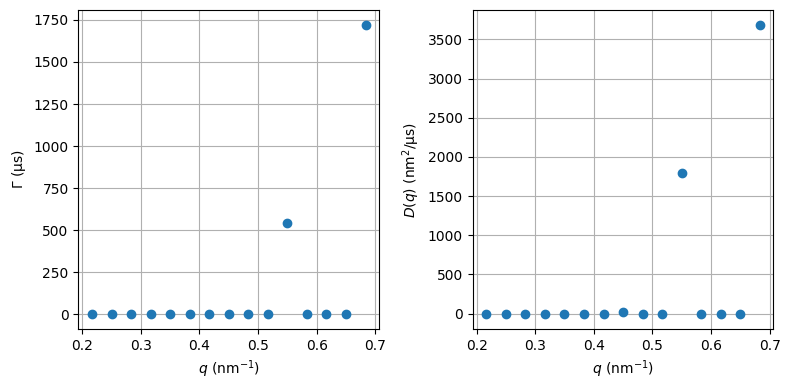

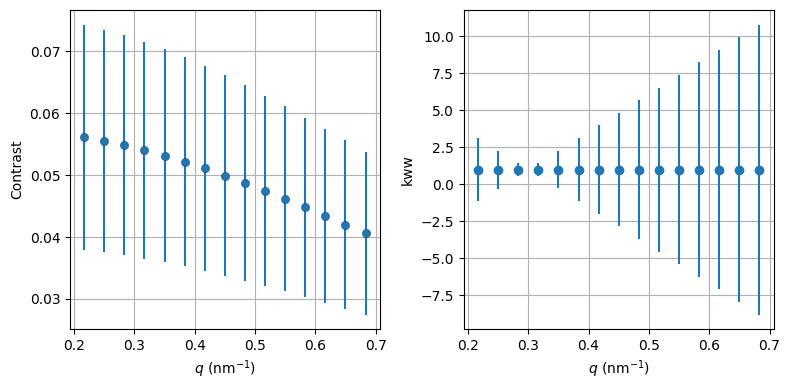

In [81]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.errorbar(qvalues[qmin:qmax],1/tau,1/tau**2*dtau,marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('$\Gamma$ (μs)')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,2,2)

plt.errorbar(qvalues[qmin:qmax],1/tau/qvalues[qmin:qmax]**2,1/tau**2*dtau/qvalues[qmin:qmax]**2,marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('$D(q)$ (nm$^2$/μs)')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')


print('kww')
print(kww)
print(1-kww*(qvalues-.1))

print('A')
print(A)
print('baseline')
print(baseline)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.errorbar(qvalues[qmin:qmax],A*contrast,dA*contrast,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('Contrast')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,2,2)

plt.errorbar(qvalues[qmin:qmax],kww_function(kww,qvalues[qmin:qmax]),np.abs(dkww*(qvalues-.3)*10),marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('kww')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')




IndexError: index 5 is out of bounds for axis 0 with size 5

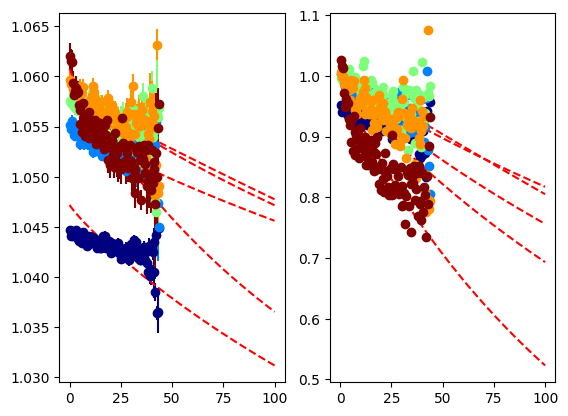

In [95]:
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
tau, A, beta, inter = (np.zeros([qnum]) for i in range(4))
dtau, dA, dbeta, dinter = (np.zeros([qnum]) for i in range(4))

deltac=0.001
qmax=9
plt.figure()

contrast =speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)/2.4

for i,q in enumerate(range(qmin,qmax)):
   
    
    popt, pcov = curve_fit(exp_fun, xdata=t, ydata=allg2[i],sigma=t**.5/100,
                           bounds=([contrast[q]-deltac,       0,       .9,   .995,],
                                   [contrast[q]+deltac,  10 ** 4,     1.1,   1.01,]),
                           p0    =([contrast[q],              .1,        1,   1.0001])  )
    A[q] = popt[0]
    dA[q] = np.sqrt(np.diag(pcov))[0]
    tau[q] = popt[1]
    dtau[q] = np.sqrt(np.diag(pcov))[1]
    beta[q] = popt[2]
    dbeta[q] = np.sqrt(np.diag(pcov))[2]
    inter[q] = popt[3]
    dinter[q] = np.sqrt(np.diag(pcov))[3]


    
    plt.subplot(1,2,1)
    plt.errorbar(t,(allg2[i]) ,alldg2[i],marker='o',ls=' ',color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.plot(t_new, (exp_fun(t_new, popt[0], popt[1], popt[2], popt[3])), color='red',linestyle='dashed')
    plt.subplot(1,2,2)
    plt.errorbar(t,(allg2[i]-popt[3])/popt[0] ,alldg2[i],marker='o',ls=' ',color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.plot(t_new, (exp_fun(t_new, popt[0], popt[1], popt[2], popt[3])-popt[3])/popt[0], color='red',linestyle='dashed')
    
plt.xscale('log')
plt.grid('on')
plt.ylim([-.05,1.05])
plt.xlabel('$t$ (μs)')
plt.ylabel('$(g_2-b)/contrast(t,q)$')

plt.subplot(1,2,1)
plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,q)$')
#plt.ylim([1.04,1.1])

contrast


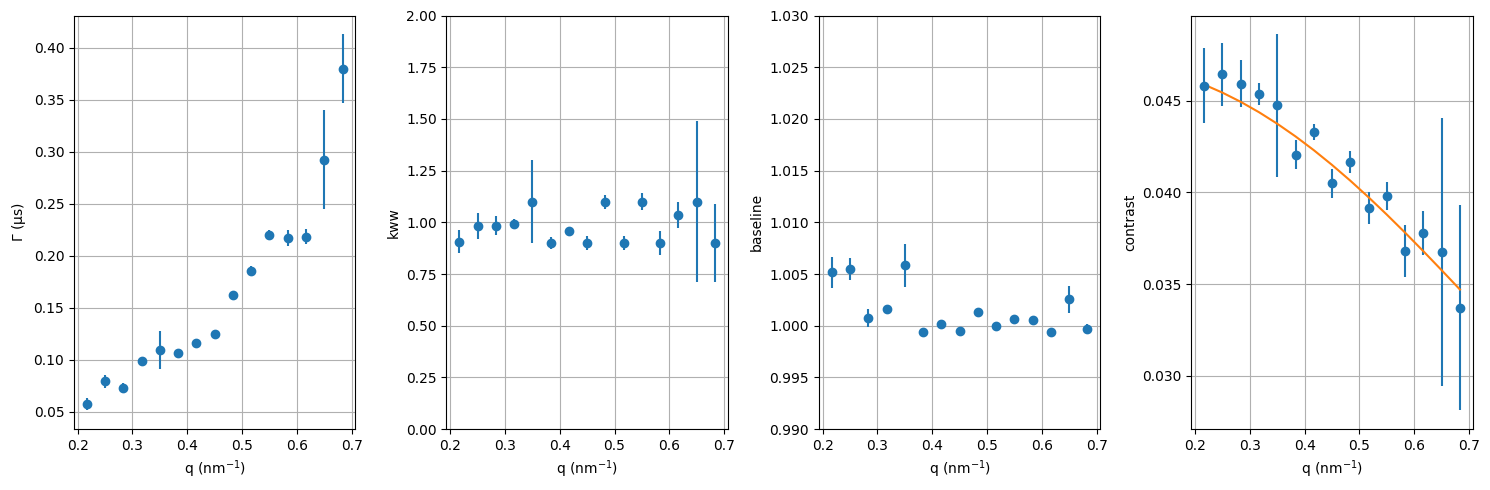

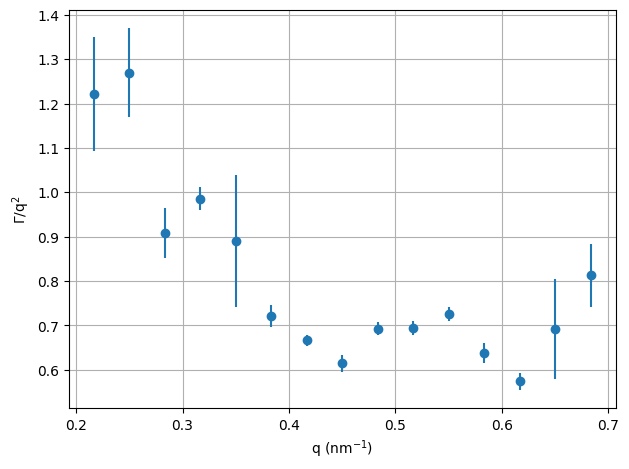

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.errorbar(qvalues[tau>0],1/tau[tau>0],1/tau[tau>0]**2*dtau[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('$\Gamma$ (μs)')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,4,2)
plt.errorbar(qvalues[tau>0],beta[tau>0],dbeta[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('kww')
plt.ylim([0,2])
plt.tight_layout()
plt.grid('on')

plt.subplot(1,4,3)
plt.errorbar(qvalues[tau>0],inter[tau>0],dinter[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('baseline')
plt.ylim([.99,1.03])
plt.tight_layout()
plt.grid('on')

plt.subplot(1,4,4)
plt.errorbar(qvalues[tau>0],A[tau>0],dA[tau>0],marker='o',ls='')
plt.plot(qvalues,contrast)
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('contrast')
#plt.ylim([0,.13])
plt.tight_layout()
plt.grid('on')



plt.figure()
plt.errorbar(qvalues[tau>0],1/tau[tau>0]/qvalues[tau>0]**2,1/tau[tau>0]**2*dtau[tau>0]/qvalues[tau>0]**2,marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('$\Gamma$/q$^2$')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

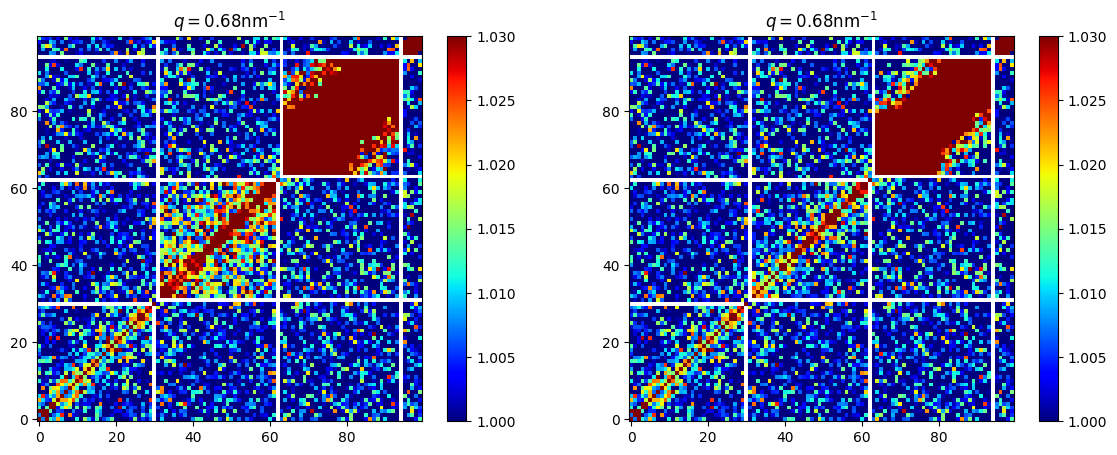

In [47]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(ave_ttc,vmin=1,vmax=1.03,origin='lower',cmap='jet')
plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ttc_baseline_correction(ave_ttc),vmin=1,vmax=1.03,origin='lower',cmap='jet')
plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
plt.colorbar()

[0.21666667 0.25       0.28333333 0.31666667 0.35       0.38333333
 0.41666667 0.45       0.48333333 0.51666667 0.55       0.58333333
 0.61666667 0.65       0.68333333]


/tmp/ipykernel_16236/2482475476.py:50: RuntimeWarning: Mean of empty slice
  ave_ttc=np.nanmean(ttcs[good_trains,q,:totframes,:totframes],axis=0)


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

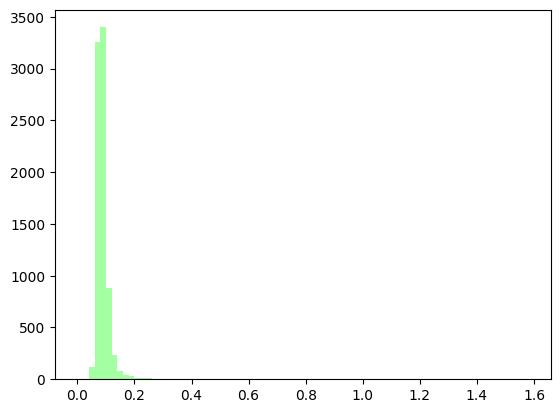

In [24]:
print(qvalues)
qmax=15
qmin=0
q=7
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))


t_new=np.arange(1000)*.1

tminframes=0

totframes=100
tmaxframes=60
tmax_mean=100

minttcmean=.96
maxttcmean=1.06


t=np.arange(tmaxframes-tminframes)*t_delay

stride=0


fig2=plt.figure(figsize=(15,10))
fig1=plt.figure(figsize=(15,10))

allg2=[]
alldg2=[]

contrast =speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
    
value_mean = np.nanmean(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
value_std  = np.nanstd(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))


plt.figure()

n_std,x,_ = plt.hist(value_std,np.arange(0,1.6,0.02),alpha=0.7,color=colore[q])
bin_centers_std = 0.5*(x[1:]+x[:-1])

high_std_threshold=bin_centers_std[n_std==max(n_std)]+(bin_centers_std[n_std==max(n_std)])*.1

filtering_mean=(value_mean>minttcmean)&(value_mean<maxttcmean)
filtering_std=(value_std<high_std_threshold)

good_trains=filtering_positions&filtering_energy&filtering_mean&filtering_std


ave_ttc=np.nanmean(ttcs[good_trains,q,:totframes,:totframes],axis=0)
ave_ttc_baselinecorrected=ttc_baseline_correction(ave_ttc) 


Text(0.5, 0, '$t_1$ (μs)')

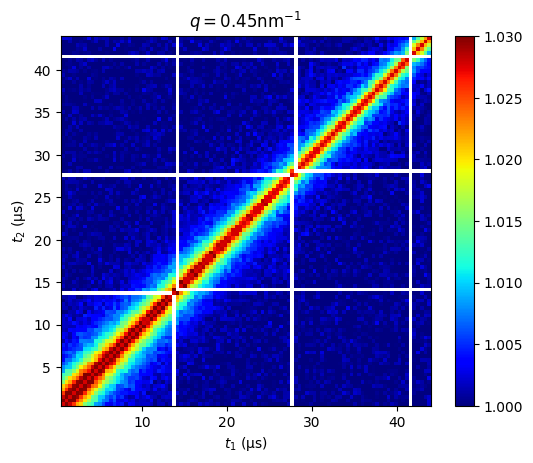

In [26]:

plt.figure()
plt.imshow(ave_ttc,vmin=1,vmax=1.03,origin='lower',cmap='jet',extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes,))
plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
plt.colorbar()

plt.ylabel('$t_2$ (μs)')
plt.xlabel('$t_1$ (μs)')

/tmp/ipykernel_16236/3365949347.py:8: RuntimeWarning: Mean of empty slice
  g2.append(np.nanmean(np.diag(ttc, k=i)))
/home/girellia/virtual_env/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0, 0.5, '$g_2 (t,t_w,q)$')

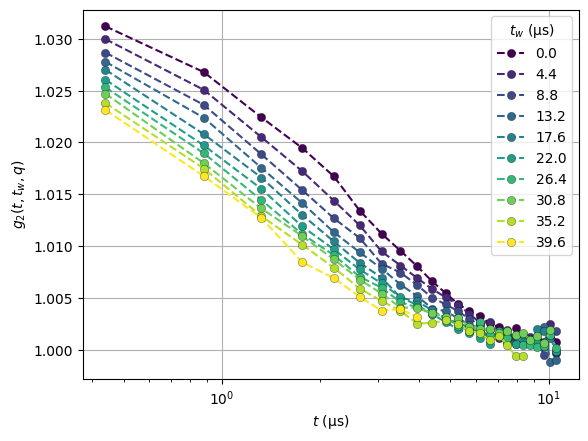

In [30]:


deltat=10
tmax=25
colore=plt.cm.viridis(np.linspace(0,1,int(100/deltat)))

plt.figure()
for i in range(int(100/deltat)):
    g2,dg2=calculate_g2(ave_ttc_baselinecorrected[i*deltat:i*deltat+tmax,i*deltat:i*deltat+tmax])
    plt.plot(t[1:len(g2)+1],g2,marker='o',ls='dashed',color=colore[i],label=str(np.round(t_delay*i*deltat,1)),markeredgewidth=.2,markeredgecolor='black')

plt.legend(title='$t_w$ (μs)')

plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,t_w,q)$')
